In [1]:
%matplotlib inline

import pandas as pd
import math
import matplotlib.pyplot as plt

increment = 1.08 # determines width of buckets for density analysis

In [2]:
def density(source):
    """
    Return a dataframe of geographies with land area and population > 0, with density calculated in persons / sq mi
    """
    # filter source to blocks with nonzero population and land area
    source = source[source.ALAND10 > 0]
    source = source[source.POP10 > 0]
    
    # calculate population density for each block
    # multiply by 2589988.11 to convert to persons / sq mi
    # (could instead multiply by 1000000 to convert to persons / sq km)
    source["density"] = source["POP10"] * 2589988.11 / source["ALAND10"]
    
    return source # this is probably bad naming practice...

In [3]:
def density_distribution(source):
    """
    Return a dataframe with density thresholds and cumulative, marginal, and percentage population at each threshold
    """
    source = density(source)
    
    # determine density buckets, geometrically distributed from source.density.min() to source.density.max()
    densitybuckets = [math.ceil(source.density.min())]
    i = densitybuckets[0]
    while i < source.density.max():
        i = math.ceil(i * increment)
        densitybuckets.append(i)
        
    # df will hold our results
    df = pd.DataFrame()
    df["threshold"] = densitybuckets
    df["cum_pop"] = 0
    df["population"] = 0 # can't call it pop because that is a function!
    
    # cumulative population
    # for each row in df, sum the populations of all blocks with density less than threshold
    # we iterate through the index backwards so we can drop blocks as we go (i.e. start with highest possible cumulative population)
    for i in reversed(list(df.index)):
        source = source[source.density < df.threshold.loc[i]]
        df.loc[i, "cum_pop"] = source.POP10.sum()
        
    # marginal population, calculated via simple subtraction
    df.loc[0, "population"] = df.loc[0, "cum_pop"]
    for i in range(1,len(df.index)):
        df.loc[i, "population"] = df.loc[i, "cum_pop"] - df.loc[i-1, "cum_pop"]
        
    # % of population
    df["pct_pop"] = df["population"] / df.population.sum()
        
    return df

In [4]:
all_CA = pd.read_csv("all_CA.csv")

In [5]:
metroareas = {}

metroareas["LA"] = [37, 59, 111, 71, 65] # Los Angeles-Long Beach-Riverside, CA CSA: Los Angeles, Orange, Ventura, San Bernardino, and Riverside Counties
metroareas["SD"] = [73] # San Diego-Carlsbad-San Marcos, CA MSA: San Diego County
metroareas["SJ"] = [85, 69] # San Jose-Sunnyvale-Santa Clara, CA MSA: Santa Clara and San Benito Counties
metroareas["SF"] = [75, 1, 41, 13, 81] # San Francisco-Oakland-Fremont, CA MSA: San Francisco, Alameda, Marin, Contra Costa, and San Mateo Counties
metroareas["Fresno"] = [19, 39] # Fresno-Madera, CA CSA: Fresno and Madera Counties
metroareas["Sacto"] = [67, 61, 113, 17] # Sacramento-Arden Arcade-Roseville, CA MSA: Sacramento, Placer, Yolo, and El Dorado Counties

In [6]:
metrosource = {}

for key, value in metroareas.items():
    metrosource[key] = all_CA[all_CA.COUNTYFP10.isin(value)] # the in operator doesn't work with pandas! but this works fine

In [7]:
metroresults = {}

for key, value in metrosource.items():
    metroresults[key] = density_distribution(value)

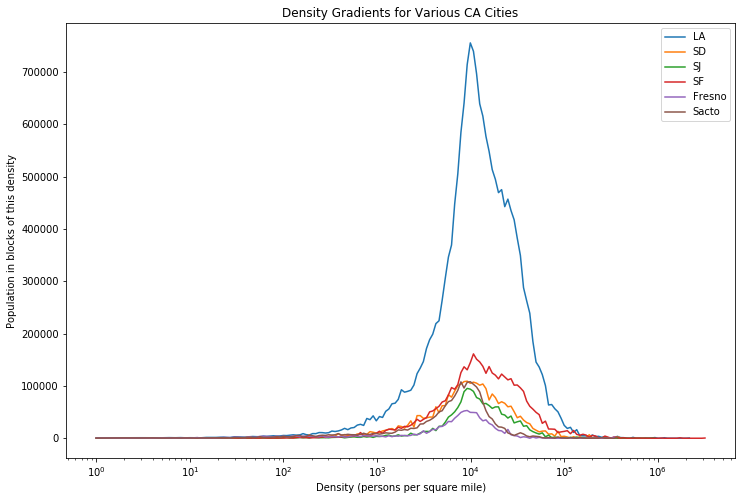

In [8]:
plt.figure(figsize=(12,8))

for key, value in metroresults.items():
    plt.semilogx(value.threshold, value.population, label = key)

plt.xlabel('Density (persons per square mile)')
plt.ylabel('Population in blocks of this density')

plt.title("Density Gradients for Various CA Cities")

plt.legend()

plt.show()

In [9]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance (in miles) between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2 + cos(lat1) * cos(lat2) * sin(dlon/2.)**2
    c = 2 * asin(sqrt(a)) 

    # 3958.761 mi is the mean radius of the Earth
    mi = 3958.761 * c
    return mi 

In [10]:
sf_density = density(metrosource["SF"])
sf_highdensity = sf_density[sf_density.density >= 15000]
indices = sf_highdensity.index.values

In [11]:
from random import randrange

tests = 10000
distance = 0

for n in range(tests):
    i = randrange(len(indices))
    j = randrange(len(indices))
    
    distance += haversine(sf_highdensity.INTPTLON10.loc[indices[i]], 
                          sf_highdensity.INTPTLAT10.loc[indices[i]], 
                          sf_highdensity.INTPTLON10.loc[indices[j]], 
                          sf_highdensity.INTPTLAT10.loc[indices[j]])

print("Approximate average distance between high-density blocks:", distance / tests, "miles")

Approximate average distance between high-density blocks: 15.09728866380649 miles


In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in("drew.levitt", "eqovjq7yrk")

trace1 = Scatter(
    x=metroresults["SF"].threshold.tolist(),
    y=metroresults["SF"].pct_pop.tolist()
)

trace2 = Scatter(
    x=metroresults["SD"].threshold.tolist(),
    y=metroresults["SD"].pct_pop.tolist()
)

trace3 = Scatter(
    x=metroresults["Fresno"].threshold.tolist(),
    y=metroresults["Fresno"].pct_pop.tolist()
)

data = Data([trace1, trace2, trace3])
layout = Layout(
    xaxis=XAxis(
        type='log',
        autorange=True
    ),
    yaxis=YAxis(
#        type='log',
        autorange=True
    )
)
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='SF, SD, Fresno')